In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

def dist(p1,p2):
    
    total_nucleotides = 4411532    

    max_dist = int(total_nucleotides / 2)
    # accounts for circularization of genome
    d1 = np.abs(p1 - p2)
    
    #print(i,j,d1)
    if d1 > max_dist:
        i,j=sorted([p1,p2])
        #print("too_far!", d1)
        i = i + total_nucleotides
        d1 = i-j
        #print("new distance", d1)
        
    return d1

In [2]:
!mkdir output/04B.pair_annotation

mkdir: cannot create directory ‘output/04B.pair_annotation’: File exists


In [3]:
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps_columns_to_keep = [
    "pos", 
    "gene_name", 
    "gene_id", 
    "is_lineage",
    "in_antigen_epitope",
    "in_antigen_protein", 
    "in_known_ABR_position",
    "known_drug", 
    "in_possible_ABR_gene", 
    "possible_drug"

]

# Add gene and lineage  annotation to the results
results = pd.read_csv("output/02B.comutation_pvalues/results_file_allpairs.csv")
results = results.merge(snps[snps_columns_to_keep], left_on="position_i", right_on="pos")
results = results.merge(snps[snps_columns_to_keep], left_on="position_j", right_on="pos", suffixes=["_i", "_j"])
results.columns

print("total pairs", len(results))
print("total non-lineage pairs", len(results.query("not is_lineage_i and not is_lineage_j")))

results = results.query("not is_lineage_i and not is_lineage_j")

results = results[[
   'position_i', 'gene_name_i','position_j', 'gene_name_j',
    'n_mutations_i',
   'n_mutations_j', 'n_branches_with_i', 'n_branches_with_j',
   'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
   'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
   'pval_beta_i_on_j', 'BH_critical_value', 'pval_beta_i_on_j_BH_sig',
    'is_lineage_i','is_lineage_j',
    'gene_id_i', 'gene_id_j', 
    "in_antigen_epitope_i",
    "in_antigen_protein_i", 
    "in_known_ABR_position_i",
    "known_drug_i", 
    "in_possible_ABR_gene_i", 
    "possible_drug_i",
    "in_antigen_epitope_j",
    "in_antigen_protein_j", 
    "in_known_ABR_position_j",
    "known_drug_j", 
    "in_possible_ABR_gene_j", 
    "possible_drug_j"
]]
results.to_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

print("total_significant", len(results.query("pval_beta_i_on_j_BH_sig")))
results.query("pval_beta_i_on_j_BH_sig").to_csv("output/04B.pair_annotation/results_significant_annotated.csv")

total pairs 150518
total non-lineage pairs 132012
total_significant 62804


In [4]:
62804/132012

0.47574462927612643

## Overall analysis of hits

In [5]:
def annotate(top_hits):
    def _separate_hits(logic_columns, current_df):
        is_hit = np.sum(current_df[logic_columns].values, axis=1) > 0

        hit_df = current_df.iloc[is_hit, :]
        current_df = current_df.iloc[~is_hit, :]
        return hit_df, current_df

    # start with the df of top hits. Get just the known antibiotic hits
    top_hits["annotation"] = 'other'
    logic_columns = ["in_known_ABR_position_i", "in_known_ABR_position_j"]

    antibiotic_hits, current_df = _separate_hits(logic_columns, top_hits)

    # if both are antibiotic, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "between_known_AB"

    # if just one, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            ~antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_second"

    antibiotic_hits.loc[
        np.logical_and(
            ~antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_first"

    # Then get the antigen proteins
    logic_columns = ['in_antigen_protein_i','in_antigen_protein_j',]

    antigen_hits, current_df = _separate_hits(logic_columns, current_df)

    # if just one, annotate that
    antigen_hits.loc[
        np.logical_or(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "one_antigen"

    antigen_hits.loc[
        np.logical_and(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "both_antigen"

    # then get the maybe antibiotic hits
    logic_columns = ["in_possible_ABR_gene_i", "in_possible_ABR_gene_j"]

    maybe_antibiotic_hits, current_df = _separate_hits(logic_columns, current_df)

    # if both are antibiotic, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "between_maybe_AB"

    # if just one, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            ~maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_second"

    maybe_antibiotic_hits.loc[
        np.logical_and(
            ~maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_first"

    return pd.concat([antigen_hits, antibiotic_hits, maybe_antibiotic_hits, current_df])

In [6]:
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv")
top_hits = annotate(top_hits)
top_hits.to_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv")
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

In [7]:
print(top_hits.groupby("annotation").size())

annotation
between_known_AB     1196
between_maybe_AB     1607
both_antigen         3721
known_AB_first       3349
known_AB_second      2970
maybe_AB_first       3280
maybe_AB_second      1524
one_antigen         15700
other               29457
dtype: int64


In [8]:
top_hits.sort_values("pval_beta_i_on_j")[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_muts_same_branch", "pval_beta_i_on_j", "annotation"
]].head(10)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_muts_same_branch,pval_beta_i_on_j,annotation
0,105060,Rv0095c,105063,Rv0095c,376,361,352,0.000000e+00,other
3588,1341114,esxL,1341120,esxL,184,222,167,0.000000e+00,both_antigen
2,761155,rpoB,2155168,katG,1687,2098,687,0.000000e+00,between_known_AB
1089,3847215,PPE59,3847221,PPE59,161,145,136,5.497857e-288,other
2431,2197331,Rv1945,2197332,Rv1945,124,126,122,6.988375e-277,both_antigen
11443,1341099,esxL,1341114,esxL,199,184,137,4.252785e-264,both_antigen
12476,3841652,None,3841654,None,114,114,113,6.451416e-262,other
3589,1341099,esxL,1341120,esxL,199,222,137,1.318227e-252,both_antigen
4,781687,rpsL,2155168,katG,918,2098,405,4.842913e-245,between_known_AB
8156,1339435,PPE18,1339436,PPE18,109,119,107,5.308867e-243,both_antigen


In [9]:
#What fraction of the top hits in terms of p value are within 100 base pairs? 
top_hits = top_hits.sort_values("pval_beta_i_on_j")
top_hits["mutation_distance"]=[dist(x,y) for x,y in zip(top_hits.position_i, top_hits.position_j)]
len(top_hits.iloc[0:100].query("mutation_distance <= 100"))

87

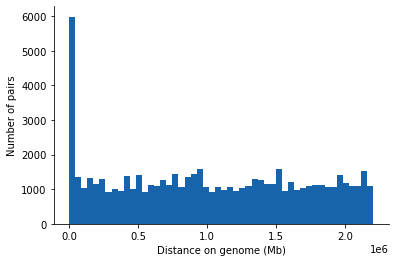

In [10]:

pal = sns.color_palette("Blues",4)

for_display = top_hits
for_display["mutation_distance"] = [dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
figure = plt.figure()
ax = figure.gca()

ax.hist(for_display.mutation_distance, 50, color=pal[3])
plt.xlabel("Distance on genome (Mb)")
plt.ylabel("Number of pairs")
sns.despine()
#plt.show()
plt.savefig("figures/simultaneous_mutations_distance.pdf")

## Characterization of simultaneous, proximal pairs

In [11]:
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv")
top_hits = annotate(top_hits)
top_hits["mutation_distance"] = [dist(x,y) for x,y in zip(top_hits.position_i, top_hits.position_j)]

top_hits.to_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv")

top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

In [12]:
# Are the near distance hits more likely to be genic or intergenic? 

all_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv", index_col=0)
all_hits["mutation_distance"] = [dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

near_hits = all_hits.query('mutation_distance <= 100')
far_hits = all_hits.query('mutation_distance > 100')

print("number of close pairs", len(near_hits), "number of far pairs", len(far_hits))
N = len(near_hits)
print("fraction intergenic", len(near_hits.query("gene_name_i == gene_name_j == 'None'"))/N, "\n",
      "fraction genic", len(near_hits.query("gene_name_i == gene_name_j != 'None'"))/N,"\n",
      "fraction not same gene/one genic one intergenic", len(near_hits.query("gene_name_i != gene_name_j"))/N,"\n"
     )


number of close pairs 2361 number of far pairs 60443
fraction intergenic 0.15586615840745446 
 fraction genic 0.8242270224481152 
 fraction not same gene/one genic one intergenic 0.019906819144430325 



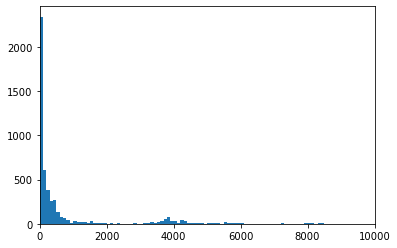

In [13]:
# At what distance are the pairs actually enriched? 
# Bin size of 100
plt.xlim([0,10000])
plt.hist(top_hits.mutation_distance, bins = np.arange(0,10000,100))
plt.savefig("figures/enrichment_by_distance.pdf")

In [14]:
## What fraction are in the same codon? 

# annotate with codon position
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv",index_col=0)
snps_aa = snps.query("AA_change != 'None'")
snps_aa["AA"] = ["".join(list(x)[1:-1]) for x in snps_aa.AA_change]

print(len(all_hits))

within_3 = all_hits.query("mutation_distance <= 100")
print(len(within_3))

within_3 = within_3.merge(snps_aa[["pos", "AA"]], left_on="position_i", right_on="pos", how="left")
within_3 = within_3.merge(snps_aa[["pos", "AA"]], left_on="position_j", 
                          right_on="pos", how="left", suffixes=["_i", "_j"])
print("number of pairs in the same codon", len(within_3.query("AA_i == AA_j")))

within_3["fraction"] = within_3.n_muts_same_branch / pd.concat(
    [within_3.n_mutations_i,within_3.n_mutations_j], axis=1
).min(axis=1)

print(len(within_3.query("AA_i == AA_j and fraction > .8")))

62804
2361
number of pairs in the same codon 115
92


In [15]:
115/2361

0.04870817450232952

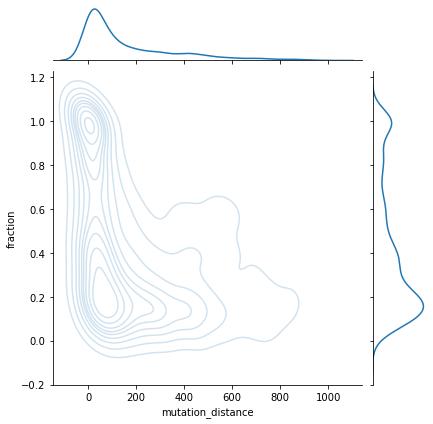

In [16]:
# fraction of times a mutation happens simultaneously compared to the # of times
# the less frequent mutation happens
top_hits["fraction"] = top_hits.n_muts_same_branch / pd.concat([top_hits.n_mutations_i,top_hits.n_mutations_j], axis=1).min(axis=1)

sns.jointplot(data = top_hits.query('mutation_distance<1000'),
                                       x="mutation_distance", 
              y="fraction", linewidth=0, alpha=0.2, kind='kde')
plt.savefig("figures/fraction_simultaneous_vs_distance_density.pdf")

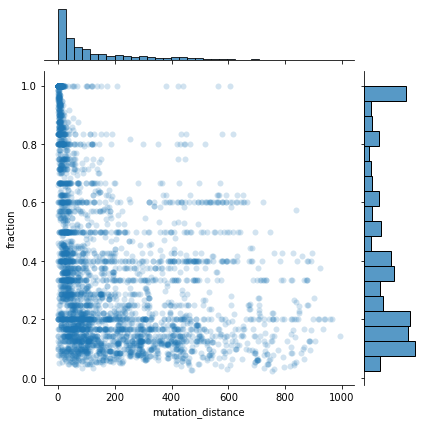

In [17]:

sns.jointplot(data = top_hits.query('mutation_distance<1000'),
                                       x="mutation_distance", 
              y="fraction", linewidth=0, alpha=0.2)
plt.savefig("figures/fraction_simultaneous_vs_distance.pdf")

## Enrichment statistics

In [18]:

all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

all_hits = annotate(all_hits)
all_hits.to_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

annotation
between_known_AB     3369
between_maybe_AB     2298
both_antigen         8872
known_AB_first      13102
known_AB_second     14790
maybe_AB_first       5948
maybe_AB_second      2874
one_antigen         36310
other               44449
dtype: int64


#### Question 1: are the overlapping hits an enrichment in some way based on our expectation from the distribution of SNPs?

In [19]:

top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

all_hits = annotate(all_hits)
all_hits.to_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

## Actual numbers: 159 epitopes, 774 antigens, 250 known resistance, 814 possible resistance, 2747 no category
total_snps = len(snps)

p_epitope = 159/total_snps
p_antigen = 774/total_snps
p_known_R = 250/total_snps
p_possible_R = (814-250)/total_snps
p_other = (total_snps - 814 -774)/total_snps

# bang this out
e_between_known_AB = p_known_R * p_known_R
e_between_maybe_AB = p_possible_R * p_possible_R
e_both_antigen = p_antigen * p_antigen

e_known_AB_first = p_known_R * (1-p_known_R)
e_known_AB_second = p_known_R * (1-p_known_R)

e_maybe_AB_first = p_possible_R * (p_other)
e_maybe_AB_second = p_possible_R * (p_other)

e_one_antigen = 2 * p_antigen * (p_other + p_possible_R)
e_other = p_other * p_other


top_hits_values = all_hits.groupby("annotation").size()
labels = all_hits.groupby("annotation").size().index

all_hits_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

print(result_df)
result_df1 = result_df
result_df1["chi_square"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[0]
result_df1["p_value"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[1]
result_df1["category"] = result_df1.index
result_df1.to_csv("output/04B.chisquare_all_pairs_vs_expected.csv")

annotation
between_known_AB     3369
between_maybe_AB     2298
both_antigen         8872
known_AB_first      13102
known_AB_second     14790
maybe_AB_first       5948
maybe_AB_second      2874
one_antigen         36310
other               44449
dtype: int64
Power_divergenceResult(statistic=60410.674337234035, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3369          366.764404
between_maybe_AB              2298         1866.660637
both_antigen                  8872         3515.516032
known_AB_first               13102         6591.489866
known_AB_second              14790         6591.489866
maybe_AB_first                5948        10442.046647
maybe_AB_second               2874        10442.046647
one_antigen                  36310        33783.473184
other                        44449        58412.512717


In [20]:
from scipy.stats import chisquare

top_hits_values = top_hits.groupby("annotation").size().values
all_hits_expectation = all_hits.groupby("annotation").size().values / len(all_hits) * len(top_hits)

print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

## Table of nice results

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_hit_freq": top_hits_values, 
    "expected_hit_freq": all_hits_expectation})

print(result_df)
result_df2 = result_df

Power_divergenceResult(statistic=7587.502894880856, pvalue=0.0)
           category  actual_hit_freq  expected_hit_freq
0  between_known_AB             1196        1602.783656
1  between_maybe_AB             1607        1093.261158
2      both_antigen             3721        4220.806351
3    known_AB_first             3349        6233.206133
4   known_AB_second             2970        7036.263067
5    maybe_AB_first             3280        2829.729055
6   maybe_AB_second             1524        1367.290065
7       one_antigen            15700       17274.287489
8             other            29457       21146.373027


In [21]:
top_hits = top_hits.sort_values("pval_beta_i_on_j")

In [22]:
top_hits.query("mutation_distance < 100").groupby("annotation").size()

annotation
between_known_AB      36
between_maybe_AB     194
both_antigen        1202
known_AB_first         6
known_AB_second        9
one_antigen           14
other                884
dtype: int64

In [23]:
top_hits.iloc[0:100].groupby("annotation").size()

annotation
between_known_AB     8
both_antigen        46
known_AB_second      1
other               45
dtype: int64

In [24]:
top_hits.groupby("annotation").size()

annotation
between_known_AB     1196
between_maybe_AB     1607
both_antigen         3721
known_AB_first       3349
known_AB_second      2970
maybe_AB_first       3280
maybe_AB_second      1524
one_antigen         15700
other               29457
dtype: int64

In [25]:
top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
top_hits_values

annotation
between_known_AB     8
both_antigen        46
known_AB_second      1
other               45
dtype: int64

In [26]:
from scipy.stats import chisquare

top_hits=top_hits.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
all_hits_expectation = top_hits.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  8, 0, 46,  0, 1, 0, 0,  0, 45],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq": top_hits_values, 
    "expected_top_hit_freq": all_hits_expectation})

print(result_df)
result_df3 = result_df
result_df3["category"] = result_df3.index

Power_divergenceResult(statistic=334.1370556231716, pvalue=2.1948988662393545e-67)
                  actual_top_hit_freq  expected_top_hit_freq
annotation                                                  
between_known_AB                  8.0               1.904337
between_maybe_AB                  NaN               2.558754
both_antigen                     46.0               5.924782
known_AB_first                    NaN               5.332463
known_AB_second                   1.0               4.728998
maybe_AB_first                    NaN               5.222597
maybe_AB_second                   NaN               2.426597
one_antigen                       NaN              24.998408
other                            45.0              46.903063


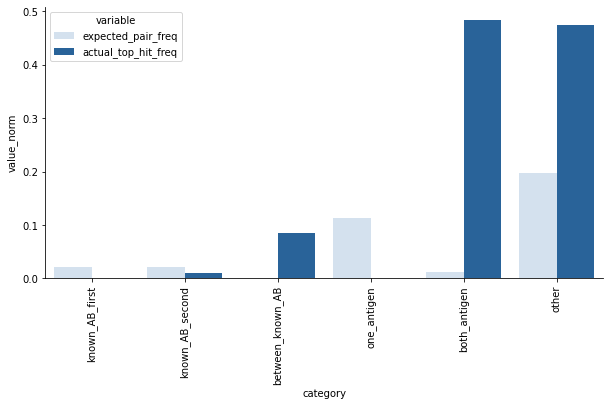

In [27]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3]]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_category.pdf")

## Repeat enrichment analysis treating the proximal mutations as separate

In [28]:
all_hits["mutation_distance"]=[dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

all_hits_close = all_hits.query("mutation_distance <= 100")
all_hits_far = all_hits.query("mutation_distance > 100")
print(len(all_hits_close), len(all_hits_far))

2578 129434


In [29]:
top_hits_values = all_hits_close.groupby("annotation").size()
top_hits_values

annotation
between_known_AB      70
between_maybe_AB     199
both_antigen        1312
known_AB_first        15
known_AB_second       20
one_antigen           33
other                929
dtype: int64

In [30]:

# need to manually define to ensure that the 0's are in place
top_hits_values = [  70, 199, 1312,   15,   20,  0, 0, 33, 929]

labels = all_hits_close.groupby("annotation").size().index

all_hits_close_expectation = np.array([
    e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
    e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other
]) * np.sum(top_hits_values)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_close_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_close_expectation))

print(result_df)
results_df1_close = result_df
#result_df1_close["category"] = 

Power_divergenceResult(statistic=25028.7338581076, pvalue=0.0)
   actual_pair_freq  expected_pair_freq
0                70            7.162369
1               199           36.453134
2              1312           68.652852
3                15          128.722092
4                20          128.722092
5                 0          203.917797
6                 0          203.917797
7                33          659.741492
8               929         1140.710373


In [31]:
top_hits_values = all_hits_far.groupby("annotation").size()

labels = all_hits_far.groupby("annotation").size().index

all_hits_far_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits_far)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_far_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_far_expectation))

print(result_df)
results_df1_far = result_df

Power_divergenceResult(statistic=57139.046666225535, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3299          359.602035
between_maybe_AB              2099         1830.207503
both_antigen                  7560         3446.863180
known_AB_first               13087         6462.767773
known_AB_second              14770         6462.767773
maybe_AB_first                5948        10238.128850
maybe_AB_second               2874        10238.128850
one_antigen                  36277        33123.731692
other                        43520        57271.802344


In [32]:

top_hits=all_hits_close.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
top_hits_values

annotation
both_antigen    52
other           48
dtype: int64

In [33]:

top_hits=all_hits_close.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_close.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  0, 0, 52,  0, 0,  0, 48],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_close": top_hits_values, 
    "expected_top_hit_freq_close": all_hits_expectation})

print(result_df)
results_df3_close = result_df
results_df3_close["category"] = results_df3_close.index

Power_divergenceResult(statistic=17.068571241040722, pvalue=0.009034511214282233)
                  actual_top_hit_freq_close  expected_top_hit_freq_close
annotation                                                              
between_known_AB                        NaN                     2.715283
between_maybe_AB                        NaN                     7.719162
both_antigen                           52.0                    50.892164
known_AB_first                          NaN                     0.581846
known_AB_second                         NaN                     0.775795
one_antigen                             NaN                     1.280062
other                                  48.0                    36.035687


In [34]:
top_hits=all_hits_far.sort_values("pval_beta_i_on_j")
top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
top_hits_values

annotation
between_known_AB    29
between_maybe_AB     2
both_antigen        10
known_AB_first       2
known_AB_second      1
maybe_AB_first       5
one_antigen         20
other               31
dtype: int64

In [35]:

top_hits=all_hits_far.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_far.groupby("annotation").size() / len(top_hits) * 100

#top_hits_values
print(chisquare([29,  2, 10,  2,  1,  5, 0,20, 31], f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_far": top_hits_values, 
    "expected_top_hit_freq_far": all_hits_expectation})

print(result_df)
results_df3_far = result_df
results_df3_far["category"] = results_df3_far.index
results_df3_far

Power_divergenceResult(statistic=298.3246367947302, pvalue=9.358750940408153e-60)
                  actual_top_hit_freq_far  expected_top_hit_freq_far
annotation                                                          
between_known_AB                     29.0                   2.548789
between_maybe_AB                      2.0                   1.621676
both_antigen                         10.0                   5.840815
known_AB_first                        2.0                  10.110945
known_AB_second                       1.0                  11.411221
maybe_AB_first                        5.0                   4.595392
maybe_AB_second                       NaN                   2.220437
one_antigen                          20.0                  28.027412
other                                31.0                  33.623314


,actual_top_hit_freq_far,expected_top_hit_freq_far,category
annotation,,,
between_known_AB,29.0,2.548789,between_known_AB
between_maybe_AB,2.0,1.621676,between_maybe_AB
both_antigen,10.0,5.840815,both_antigen
known_AB_first,2.0,10.110945,known_AB_first
known_AB_second,1.0,11.411221,known_AB_second
maybe_AB_first,5.0,4.595392,maybe_AB_first
maybe_AB_second,NaN,2.220437,maybe_AB_second
one_antigen,20.0,28.027412,one_antigen
other,31.0,33.623314,other


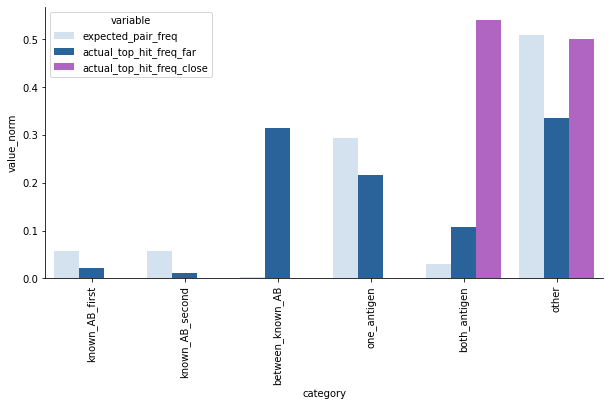

In [36]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

results_df1_far["category"] = results_df3_far.index

toplot1 = _process_result_df(results_df1_far).fillna(0)
toplot2 = _process_result_df(results_df3_close).fillna(0)
toplot3 = _process_result_df(results_df3_far).fillna(0)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq_far", "actual_top_hit_freq_close"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_top_hit_freq_far",  "actual_top_hit_freq_close"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3],"mediumorchid"]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_far_category.pdf")

In [38]:
all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")
all_hits["mutation_distance"] = [dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

all_hits.to_csv("_max_all_simultaneous_pairs.csv")
all_hits.query("mutation_distance < 100 and pval_beta_i_on_j_BH_sig").to_csv("_max_significant_proximal_pairs.csv")

In [56]:
pd.read_csv("output/03.annotation/snps_with_all_annotation.csv")

,Unnamed: 0,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,in_antigen_protein,AA_change,aa_position,in_antigen_epitope,in_known_ABR_position,known_drug,in_possible_ABR_gene,possible_drug,in_essential_gene_minato
0,0,290,G,"['C', 'T']",Rv0001,289.0,Essential,dnaA,False,False,G97A,97,False,False,NaN,False,NaN,True
1,2,490,G,['A'],Rv0001,489.0,Essential,dnaA,False,False,G164S,164,False,False,NaN,False,NaN,True
2,3,573,G,"['C', 'T']",Rv0001,572.0,Essential,dnaA,False,False,L191F,191,False,False,NaN,False,NaN,True
3,5,696,G,"['A', 'C', 'T']",Rv0001,695.0,Essential,dnaA,False,False,M232I,232,False,False,NaN,False,NaN,True
4,8,697,C,['T'],Rv0001,696.0,Essential,dnaA,False,False,R233W,233,False,False,NaN,False,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,7274,4408156,A,"['C', 'G']",Rv3919c,628.0,Antibiotic Resistance,gid,True,False,L16R,16,False,False,NaN,True,STM,False
4739,7276,4408168,A,"['C', 'G']",Rv3919c,640.0,Antibiotic Resistance,gid,False,False,F12C,12,False,False,NaN,True,STM,False
4740,7278,4408185,G,"['A', 'C']",Rv3919c,657.0,Antibiotic Resistance,gid,False,False,P6P,6,False,False,NaN,True,STM,False
4741,7280,4408806,G,['A'],Rv3920c,472.0,Non-Essential,Rv3920c,False,False,A31V,31,False,False,NaN,False,NaN,False


In [57]:
pd.read_csv("output/01.mutation_and_comutation_data/first_order_statistics.csv")


,Unnamed: 0,pos,n_mutations,n_reversions,n_branches_with,mat_index
0,0,290,5,0,4,0
1,1,490,5,0,10,1
2,2,573,7,0,2,2
3,3,696,8,0,4,3
4,4,697,8,0,0,4
...,...,...,...,...,...,...
4738,4738,4408156,7,2,11371,4738
4739,4739,4408168,5,0,0,4739
4740,4740,4408185,6,0,46,4740
4741,4741,4408806,5,0,8,4741


In [42]:
close_hits = all_hits.query("mutation_distance < 100 and pval_beta_i_on_j_BH_sig")

In [45]:
len(close_hits.gene_name_i.unique())

82

In [54]:
sorted(close_hits.gene_name_i.unique())

['None',
 'PE_PGRS17',
 'PE_PGRS18',
 'PE_PGRS20',
 'PE_PGRS21',
 'PPE18',
 'PPE19',
 'PPE24',
 'PPE27',
 'PPE34',
 'PPE35',
 'PPE40',
 'PPE5',
 'PPE54',
 'PPE55',
 'PPE56',
 'PPE59',
 'PPE6',
 'PPE60',
 'PPE8',
 'Rv0095c',
 'Rv0331',
 'Rv0397',
 'Rv0740',
 'Rv0750',
 'Rv0813c',
 'Rv1129c',
 'Rv1148c',
 'Rv1288',
 'Rv1318c',
 'Rv1319c',
 'Rv1435c',
 'Rv1566c',
 'Rv1944c',
 'Rv1945',
 'Rv2021c',
 'Rv2082',
 'Rv2390c',
 'Rv2824c',
 'Rv2825c',
 'Rv2980',
 'Rv3405c',
 'Rv3424c',
 'Rv3466',
 'Rv3900c',
 'Rv3901c',
 'ald',
 'cyp130',
 'dnaA',
 'eccD1',
 'embB',
 'espA',
 'esxJ',
 'esxL',
 'esxM',
 'esxN',
 'esxO',
 'esxW',
 'ethA',
 'fadD18',
 'fadE35',
 'folC',
 'folP2',
 'gid',
 'gyrA',
 'katG',
 'lipN',
 'lppA',
 'lppB',
 'mycP1',
 'pks12',
 'pncA',
 'ppsA',
 'ppsB',
 'prpD',
 'rpoB',
 'rpoC',
 'ubiA',
 'vapB31',
 'vapC25',
 'vapC31',
 'whiB6']

In [55]:
sorted(close_hits.query("not in_possible_ABR_gene_i").gene_name_i.unique())

['None',
 'PE_PGRS17',
 'PE_PGRS18',
 'PE_PGRS20',
 'PE_PGRS21',
 'PPE18',
 'PPE19',
 'PPE24',
 'PPE27',
 'PPE34',
 'PPE40',
 'PPE5',
 'PPE54',
 'PPE55',
 'PPE56',
 'PPE59',
 'PPE6',
 'PPE60',
 'PPE8',
 'Rv0095c',
 'Rv0331',
 'Rv0397',
 'Rv0740',
 'Rv0750',
 'Rv0813c',
 'Rv1129c',
 'Rv1148c',
 'Rv1288',
 'Rv1318c',
 'Rv1319c',
 'Rv1435c',
 'Rv1566c',
 'Rv1944c',
 'Rv1945',
 'Rv2021c',
 'Rv2082',
 'Rv2390c',
 'Rv2824c',
 'Rv2825c',
 'Rv2980',
 'Rv3405c',
 'Rv3424c',
 'Rv3466',
 'Rv3900c',
 'Rv3901c',
 'ald',
 'cyp130',
 'dnaA',
 'eccD1',
 'espA',
 'esxJ',
 'esxL',
 'esxM',
 'esxN',
 'esxO',
 'esxW',
 'fadD18',
 'fadE35',
 'folC',
 'folP2',
 'lipN',
 'lppA',
 'lppB',
 'mycP1',
 'pks12',
 'ppsA',
 'ppsB',
 'prpD',
 'vapB31',
 'vapC25',
 'vapC31']

In [53]:
close_hits.columns

Index(['Unnamed: 0', 'position_i', 'gene_name_i', 'position_j', 'gene_name_j',
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
       'n_branches_with_j', 'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
       'n_muts_same_branch', 'n_branch_with_i_no_j', 'n_branch_with_j_no_i',
       'n_branch_i_and_j', 'pval_beta_i_on_j', 'BH_critical_value',
       'pval_beta_i_on_j_BH_sig', 'is_lineage_i', 'is_lineage_j', 'gene_id_i',
       'gene_id_j', 'in_antigen_epitope_i', 'in_antigen_protein_i',
       'in_known_ABR_position_i', 'known_drug_i', 'in_possible_ABR_gene_i',
       'possible_drug_i', 'in_antigen_epitope_j', 'in_antigen_protein_j',
       'in_known_ABR_position_j', 'known_drug_j', 'in_possible_ABR_gene_j',
       'possible_drug_j', 'mutation_distance'],
      dtype='object')